# Stree view house number

The result when we train the model with extra dataset is better than the one we train on train dataset.
The distribution of samples in train set is different with the distribution of samples in extra set.
Numbers in the images of extra set are bigger, and less noise than images in train set.
To improve the accuracy on train set we only using image in bounding box to predict number.
There are 2 steps:
1. Detect the bounding box. Cut image base on the predicted bounding box.
2. Using the drop images in step on to predict number.

In this tutorial I want to combine 2 step into one model, an end to end system.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.plots import *
import pandas as pd
from fastai.conv_learner import *
from fastai.dataset import *

In [3]:
ls /fast/data/SVHN

extra/            models/          test.tar.gz      train_length.csv
extra_boxes.csv   test/            tmp/             train.tar.gz
extra.csv         test_boxes.csv   train/
extra_length.csv  test.csv         train_boxes.csv
extra.tar.gz      test_length.csv  train.csv


In [4]:
home_dir = '/fast/data/SVHN/'

In [5]:
train_df = pd.read_csv(os.path.join(home_dir, 'train.csv'))

In [6]:
max([len(l.split(' ')) for l in list(train_df.tags)])

6

In [7]:
train_df.sample(3)

,image_name,tags
11020,19917,1 10
22964,30666,1 5
26688,3956,1 10 7


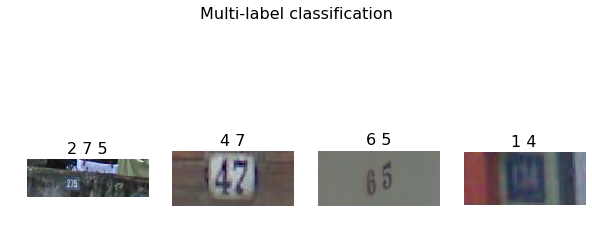

In [8]:
samples = train_df.sample(4)
list_paths = [f"{home_dir}train/{i}.png" for i in list(samples['image_name'])]
titles=list(samples['tags'])
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In [9]:
f_model = resnet34

In [10]:
label_csv = os.path.join(home_dir, 'train.csv')
bb_csv = os.path.join(home_dir, 'train_boxes.csv')
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [11]:
train_df = pd.read_csv(label_csv)
train_df['tags'] = train_df.tags.apply(lambda x: [int(i) if int(i) != 10 else 0 for i in x.split(' ')])

In [12]:
((val_label,trn_label),) = split_by_idx(val_idxs, train_df)

In [13]:
def get_data(sz, bs=30):
    aug_tfms = [RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD), 
                RandomStretch(max_stretch=0.5, tfm_y=TfmType.COORD),
               ]
    tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
    return ImageClassifierData.from_csv(home_dir, 'train', bb_csv, tfms=tfms, bs=bs, 
                                        suffix='.png', val_idxs=val_idxs, test_name='test',
                                        continuous=True, num_workers=4)

In [14]:
sz = 64
data = get_data(64)

In [15]:
x, y = data.trn_ds[0]

In [16]:
x.shape, y

((3, 64, 64), array([ 9., 22., 58., 27.,  9., 28., 59., 35.], dtype=float32))

In [17]:
y

array([ 9., 22., 58., 27.,  9., 28., 59., 35.], dtype=float32)

In [18]:
from matplotlib import patches, patheffects
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

def get_big_bounding_box(boxes):
    # top, left, bottom, right
    return np.array([min(boxes[:, 0]), min(boxes[:,1]), max(boxes[:, 2]), max(boxes[:, 3])])

def draw_im(im, boxes, cats, draw_one_box=False):
    ax = show_img(im, figsize=(8,4))
    if draw_one_box:
        b = bb_hw(boxes)
        draw_rect(ax, b)
    else:
        for b, c in zip(boxes, cats):
            b = bb_hw(b)
            draw_rect(ax, b)
            draw_text(ax, b[:2], c, sz=16)

In [19]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, labels, sz):
        self.ds,self.labels = ds,labels
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x, y = self.ds[i]
        boxes = y.reshape((-1, 4))
        box = get_big_bounding_box(boxes) / sz
        return (x, ((len(self.labels[i])-1), box, np.array(self.labels[i])))
#         return (x, (y, np.array(self.labels[i]), len(self.labels[i])-1))

In [20]:
len(trn_label), len(val_label)

(26722, 6680)

In [21]:
trn_ds2 = ConcatLblDataset(data.trn_ds, list(trn_label.tags), sz)
val_ds2 = ConcatLblDataset(data.val_ds, list(val_label.tags), sz)
data.trn_dl.dataset = trn_ds2
data.val_dl.dataset = val_ds2

In [22]:
x, y = data.trn_ds[4]
print(x.shape, y)

(3, 64, 64) (2, array([0.29688, 0.34375, 0.8125 , 0.60938], dtype=float32), array([1, 5, 3]))


(1, array([0.10938, 0.375  , 0.78125, 0.59375], dtype=float32), array([1, 5]))


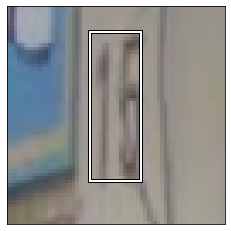

In [23]:
x, y = data.trn_ds[117]
img = data.val_ds.ds.denorm(to_np(x))[0]
boxes = y[1] * sz
draw_im(img, boxes, y[1], draw_one_box=True)
print(y)

In [24]:
class CountHead(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.adaptive = AdaptiveConcatPool2d((2,2))
        self.flatten = Flatten()
        self.layer1 = nn.Sequential(nn.Dropout(p=0.2), nn.Linear(n, 1024), nn.BatchNorm1d(1024), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(1024, 512), nn.BatchNorm1d(512), nn.ReLU())
        self.layer31 = nn.Sequential(nn.Linear(512, 6))
        self.layer32 = nn.Sequential(nn.Linear(512, 4), nn.Sigmoid())
        self.layer33 = nn.Linear(512, 10 * 6)
    def forward(self, xs):
        out = self.adaptive(xs)
        out = self.flatten(out)
        out = self.layer1(out)
        out = self.layer2(out)
        label = self.layer31(out)
        box = self.layer32(out)
        
        # extract bounding box information:
        batch_size, h, w = xs.shape[0], xs.shape[2], xs.shape[3]
        square_size = torch.tensor([h, w, h, w]).type(torch.cuda.FloatTensor)
        num_boxes = torch.mul(box, square_size).type(torch.cuda.LongTensor) + torch.tensor([0, 0, 1, 1]).type(torch.cuda.LongTensor)
        num_boxes[:, 2:4] = torch.clamp(num_boxes[:, 2:4], min=1, max=h-1)
        num_boxes[:, 0:2] = torch.clamp(num_boxes[:, 0:2], min=0, max=h-1)
        
        batch = list()
        for i in range(batch_size):
            x = xs[i:i+1]
            num_box = num_boxes[i]
            drop_box = x[:, :, num_box[0]: max(num_box[0] + 1, num_box[2] + 1), num_box[1]: max(num_box[1]+1, num_box[3] + 1)]
            batch.append(AdaptiveConcatPool2d((2,2))(drop_box))
            
            
        new_x = torch.cat(batch, 0)
        num_out = self.flatten(new_x)
        num_out = self.layer1(num_out)
        num_out = self.layer2(num_out)
        
        
        nums = self.layer33(num_out).reshape(-1, 6, 10)
        return [label, box, nums]

In [25]:
def custome_accuracy(input:list, targs:list):
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    input = input[0]
    targs = targs[0]
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    return (input==targs).float().mean()

def custome_accuracy_with_confidence_90(input:list, targs:list):
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    THREADHOLD = 0.9
    input = input[0]
    targs = targs[0]
    max_v, n_nums = nn.Softmax()(input).max(dim=1)
    mark = max_v > THREADHOLD
    return (n_nums[mark] == targs[mark]).float().sum() / mark.float().sum()

def custome_accuracy_with_confidence_95(input:list, targs:list):
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    THREADHOLD = 0.95
    input = input[0]
    targs = targs[0]
    max_v, n_nums = nn.Softmax()(input).max(dim=1)
    mark = max_v > THREADHOLD
    return (n_nums[mark] == targs[mark]).float().sum() / mark.float().sum()

def num_accuracy(pred:list, labels:list):
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    n_sample = 0.0
    true_case = 0.0
    n_nums = pred[0].argmax(dim=1) + 1
    batch_size = pred[N_NUMBER_INDEX].shape[0]
    for i in range(batch_size):
        n_sample += 1
        pred_num = int(''.join([str(j.item()) for j in pred[NUMBER_INDEX][i][-n_nums[i]:].argmax(dim=1)]))
        true_num = int(''.join([str(j.item()) for j in labels[NUMBER_INDEX][i]]))
        if pred_num == true_num:
            true_case += 1
    return true_case / n_sample

In [26]:
count_head = CountHead(1024*4)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=count_head)
learn = ConvLearner(data, models, metrics=[custome_accuracy, 
                                           custome_accuracy_with_confidence_90,
                                           custome_accuracy_with_confidence_95,
                                           num_accuracy])
learn.opt_fn = optim.Adam

In [27]:
# count_head

In [28]:
NUMBER_INDEX = 2
N_NUMBER_INDEX= 0

In [29]:
class MSECustomize(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.CrossEntropyLoss()
        self.num_loss = nn.CrossEntropyLoss()
        self.box_loss = nn.L1Loss()
    def forward(self, pred, targ):
        batch_size = pred[N_NUMBER_INDEX].shape[0]
        num_loss = sum([self.num_loss(pred[NUMBER_INDEX][i][-(targ[N_NUMBER_INDEX][i] + 1):], targ[NUMBER_INDEX][i][-(targ[N_NUMBER_INDEX][i] + 1):]) for i in range(batch_size)])/ batch_size
        return 2 * num_loss + self.loss(pred[0], targ[0]) + 10 * self.box_loss(pred[1], targ[1]) 

In [30]:
class BoxesLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.CrossEntropyLoss()
        self.box_loss = nn.L1Loss()
    def forward(self, pred, targ):
        batch_size = pred[N_NUMBER_INDEX].shape[0]
        return self.loss(pred[0], targ[0]) + 10 * self.box_loss(pred[1], targ[1]) 

In [31]:
learn.crit = BoxesLoss()

In [32]:
# learn.summary()

In [33]:
sz = 256
data = get_data(sz)
trn_ds2 = ConcatLblDataset(data.trn_ds, list(trn_label.tags), sz)
val_ds2 = ConcatLblDataset(data.val_ds, list(val_label.tags), sz)
data.trn_dl.dataset = trn_ds2
data.val_dl.dataset = val_ds2

In [34]:
images, labels = next(iter(data.trn_dl))

In [35]:
pred = learn.model(images)

In [36]:
# learn.lr_find(1e-5,10.)
# learn.sched.plot()

In [37]:
# Learn bounding box:

In [38]:
lr = 3e-4

In [39]:
sz = 64
data = get_data(sz)
trn_ds2 = ConcatLblDataset(data.trn_ds, list(trn_label.tags), sz)
val_ds2 = ConcatLblDataset(data.val_ds, list(val_label.tags), sz)
data.trn_dl.dataset = trn_ds2
data.val_dl.dataset = val_ds2

In [40]:
# Learn bounding box:
learn.crit = BoxesLoss()
learn.set_data(data)
learn.freeze()
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   custome_accuracy custome_accuracy_with_confidence_90 custome_accuracy_with_confidence_95 num_accuracy 
    0      1.338624   1.273758   0.671856   nan        nan        0.013623  
    1      1.258002   1.23792    0.685629   nan        nan        0.008084  
    2      1.233993   1.207386   0.691018   nan        nan        0.009581  



[1.2073862887249736, 0.6910180027434926, nan, nan, 0.009580838323353293]

In [41]:
# Learn number:
learn.crit = MSECustomize()
learn.set_data(data)
learn.freeze()
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   custome_accuracy custome_accuracy_with_confidence_90 custome_accuracy_with_confidence_95 num_accuracy 
    0      5.366497   5.313238   0.693862   nan        nan        0.047156  
    1      5.241191   5.220681   0.695659   nan        nan        0.064371  
    2      5.073601   5.15593    0.699102   nan        nan        0.070359  



[5.155930270691831, 0.6991018352215875, nan, nan, 0.07035928143712575]

In [42]:
lrs = [lr/100, lr/10, lr]
learn.freeze_to(-2)
learn.fit(lrs, 3, cycle_len=1)

epoch      trn_loss   val_loss   custome_accuracy custome_accuracy_with_confidence_90 custome_accuracy_with_confidence_95 num_accuracy 
    0      4.940382   4.921805   0.725      nan        nan        0.097006  
    1      4.420212   4.427172   0.768862   nan        nan        0.155838  
    2      3.971183   4.002175   0.784431   0.970032   nan        0.212425  



[4.0021753682347825,
 0.7844311833203196,
 0.9700322884642435,
 nan,
 0.2124251497005988]

In [43]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save('svhn_number_001_loop')

epoch      trn_loss   val_loss   custome_accuracy custome_accuracy_with_confidence_90 custome_accuracy_with_confidence_95 num_accuracy 
    0      3.810552   3.874919   0.793413   0.969759   nan        0.238623  
    1      3.486251   3.503978   0.810778   0.971507   0.985244   0.300898  
    2      3.137807   3.406607   0.817665   0.96755    0.987056   0.319311  
    3      3.19423    3.287876   0.815868   0.971082   0.986842   0.341018  
    4      2.853803   3.152451   0.828743   0.969946   0.984428   0.372754  
    5      2.492266   3.081092   0.836228   0.964857   0.981075   0.38503   
    6      2.378922   3.070494   0.838174   0.961496   0.981028   0.388772  



In [44]:
sz = 128
data = get_data(sz)
trn_ds2 = ConcatLblDataset(data.trn_ds, list(trn_label.tags), sz)
val_ds2 = ConcatLblDataset(data.val_ds, list(val_label.tags), sz)
data.trn_dl.dataset = trn_ds2
data.val_dl.dataset = val_ds2

In [45]:
# Learn bounding box:
learn.crit = BoxesLoss()
learn.set_data(data)
learn.freeze()
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   custome_accuracy custome_accuracy_with_confidence_90 custome_accuracy_with_confidence_95 num_accuracy 
    0      1.155528   1.082563   0.750449   0.962329   nan        0.109431  
    1      1.09838    1.031869   0.766617   0.955989   nan        0.120509  
    2      1.067381   0.999638   0.776647   0.965432   nan        0.120808  



[0.9996383666635273,
 0.7766467513081556,
 0.9654316371251009,
 nan,
 0.12080838323353293]

In [46]:
# Learn number:
learn.crit = MSECustomize()
learn.set_data(data)
learn.freeze()
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   custome_accuracy custome_accuracy_with_confidence_90 custome_accuracy_with_confidence_95 num_accuracy 
    0      4.255249   3.993667   0.777994   0.960462   0.978176   0.223503  
    1      3.984775   3.857815   0.779042   0.969867   0.97772    0.242964  
    2      3.916548   3.768525   0.781437   0.970035   0.981008   0.25524   



[3.7685254137673065,
 0.7814371734857559,
 0.9700353788936923,
 0.981007627830534,
 0.25523952095808383]

In [47]:
lrs = [lr/100, lr/10, lr]
learn.freeze_to(-2)
learn.fit(lrs, 3, cycle_len=1)

epoch      trn_loss   val_loss   custome_accuracy custome_accuracy_with_confidence_90 custome_accuracy_with_confidence_95 num_accuracy 
    0      2.901668   2.714845   0.848952   0.974249   0.987579   0.453892  
    1      2.472511   2.452881   0.862425   0.974977   0.987521   0.492515  
    2      2.308349   2.317174   0.866317   0.971247   0.984382   0.526048  



[2.3171738730576226,
 0.8663174154872666,
 0.9712471302576408,
 0.984381752545962,
 0.5260479041916167]

In [48]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save('svhn_number_002_loop')

epoch      trn_loss   val_loss   custome_accuracy custome_accuracy_with_confidence_90 custome_accuracy_with_confidence_95 num_accuracy 
    0      2.129749   2.34173    0.862275   0.97719    0.988203   0.523204  
    1      2.157051   2.230696   0.873503   0.966668   0.98434    0.557635  
    2      1.770697   2.159324   0.879341   0.965015   0.978204   0.572006  
    3      1.833948   2.157694   0.877545   0.966578   0.978652   0.578892  
    4      1.527544   2.118068   0.883084   0.959929   0.970534   0.59012   
    5      1.251787   2.099668   0.88488    0.95901    0.973652   0.598503  
    6      1.12534    2.092161   0.887425   0.954658   0.968403   0.603593  



In [49]:
sz = 256
data = get_data(sz)
trn_ds2 = ConcatLblDataset(data.trn_ds, list(trn_label.tags), sz)
val_ds2 = ConcatLblDataset(data.val_ds, list(val_label.tags), sz)
data.trn_dl.dataset = trn_ds2
data.val_dl.dataset = val_ds2

In [50]:
learn.set_data(data)
learn.freeze()
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   custome_accuracy custome_accuracy_with_confidence_90 custome_accuracy_with_confidence_95 num_accuracy 
    0      3.251029   2.905887   0.814222   0.974655   0.984908   0.42515   
    1      3.067177   2.714768   0.828743   0.978937   0.990522   0.451347  
    2      2.853111   2.618495   0.841467   0.978312   0.987325   0.467066  



[2.61849510384177,
 0.8414671160503776,
 0.9783118052218489,
 0.9873251382283822,
 0.46706586826347307]

In [51]:
# Learn num:

In [52]:
learn.crit = MSECustomize()
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   custome_accuracy custome_accuracy_with_confidence_90 custome_accuracy_with_confidence_95 num_accuracy 
    0      2.739811   2.560258   0.842964   0.978483   0.989691   0.482186  
    1      2.705051   2.499495   0.84491    0.9714     0.988355   0.491766  
    2      2.666626   2.488034   0.838323   0.971034   0.987592   0.492814  



[2.4880342990338447,
 0.8383234035290644,
 0.9710344524976022,
 0.9875918082491366,
 0.492814371257485]

In [53]:
lrs = [lr/100, lr/10, lr]
learn.freeze_to(-2)
learn.fit(lrs, 3, cycle_len=1)

epoch      trn_loss   val_loss   custome_accuracy custome_accuracy_with_confidence_90 custome_accuracy_with_confidence_95 num_accuracy 
    0      1.984417   1.917441   0.886377   0.980718   0.988591   0.618713  
    1      1.717103   1.776294   0.891767   0.977278   0.988005   0.656886  
    2      1.584911   1.679127   0.900299   0.976853   0.985694   0.672006  



[1.6791270174487622,
 0.9002994490776234,
 0.976852514518949,
 0.9856941804379046,
 0.6720059880239521]

In [54]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save('svhn_number_003_loop')

epoch      trn_loss   val_loss   custome_accuracy custome_accuracy_with_confidence_90 custome_accuracy_with_confidence_95 num_accuracy 
    0      1.498481   1.703292   0.902246   0.975495   0.98394    0.679192  
    1      1.388494   1.681299   0.899401   0.970151   0.981946   0.69012   
    2      1.102813   1.609097   0.905539   0.972059   0.98382    0.701946  
    3      1.205226   1.674666   0.901048   0.96774    0.97794    0.699401  
    4      0.994819   1.618513   0.90509    0.969452   0.978808   0.715868  
    5      0.787904   1.614078   0.907485   0.969326   0.97693    0.724401  
    6      0.693432   1.619889   0.911078   0.966019   0.974009   0.726796  



In [55]:
learn.load('svhn_number_003_loop')

In [56]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save('svhn_number_004_loop')

epoch      trn_loss   val_loss   custome_accuracy custome_accuracy_with_confidence_90 custome_accuracy_with_confidence_95 num_accuracy 
    0      0.795473   1.638134   0.907934   0.962953   0.973137   0.724551  
    1      0.831317   1.682233   0.910329   0.960886   0.970284   0.729491  
    2      0.644479   1.66585    0.910329   0.963727   0.971796   0.734731  
    3      0.842295   1.702354   0.905988   0.963098   0.974168   0.717066  
    4      0.6569     1.736237   0.905988   0.95684    0.968644   0.73503   
    5      0.533079   1.73762    0.913024   0.957687   0.967905   0.737725  
    6      0.474842   1.701644   0.916467   0.958121   0.966762   0.742365  



In [57]:
learn.unfreeze()
learn.fit(lrs, 6, cycle_len=1, cycle_mult=2)
learn.save('svhn_number_005_loop')

epoch      trn_loss   val_loss   custome_accuracy custome_accuracy_with_confidence_90 custome_accuracy_with_confidence_95 num_accuracy 
    0      0.510724   1.736651   0.911826   0.955517   0.96918    0.744311  
    1      0.604302   1.777652   0.905539   0.956708   0.967534   0.728593  
    2      0.460808   1.741974   0.911826   0.955979   0.96484    0.748503  
    3      0.643587   1.880819   0.906737   0.951859   0.961552   0.728293  
    4      0.502805   1.840989   0.911527   0.954365   0.964705   0.745659  
    5      0.412071   1.79381    0.916317   0.955634   0.964546   0.754192  
    6      0.398235   1.787378   0.914371   0.955732   0.963324   0.755539  
    7      0.624202   1.828922   0.911826   0.959093   0.968582   0.732036  
    8      0.538609   1.936954   0.908683   0.951981   0.961723   0.738772  
    9      0.466003   1.899947   0.911976   0.955116   0.963831   0.744162  
    10     0.409123   1.888429   0.910778   0.952337   0.962601   0.748802  
    11     0.3726

In [58]:
ls /fast/data/SVHN/models

svhn_001.h5                     svhn_number_003_loop.h5
svhn_001_resnet32.h5            svhn_number_003_num_boost.h5
svhn_002.h5                     svhn_number_003_num_extra.h5
svhn_002_resnet32.h5            svhn_number_003_pool2_extra.h5
svhn_003.h5                     svhn_number_003_pool2.h5
svhn_003_resnet32.h5            svhn_number_003_pool3.h5
svhn_box_001.h5                 svhn_number_004.h5
svhn_box_002.h5                 svhn_number_004_loop.h5
svhn_box_003.h5                 svhn_number_004_num_boost.h5
svhn_box_004.h5                 svhn_number_004_num_extra.h5
svhn_number_001.h5              svhn_number_004_pool2_extra.h5
svhn_number_001_loop.h5         svhn_number_004_pool2.h5
svhn_number_001_pool2.h5        svhn_number_004_pool3.h5
svhn_number_001_pool3.h5        svhn_number_005.h5
svhn_number_002.h5              svhn_number_005_loop.h5
svhn_number_002_loop.h5         svhn_number_005_num_boost.h5
svhn_number_002_pool2_extra.h5  svhn_number_005_pool2.h5
svhn_number_00